In [1]:
%matplotlib inline
import os

import rasterio
import random
import json
import sys
import datacube
import matplotlib
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from geopy.geocoders import Nominatim 
from shapely import speedups
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import triangulate
from shapely.strtree import STRtree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from deafrica_tools.plotting import display_map, map_shapefile, plot_lulc, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.dask import create_local_dask_cluster
from datacube.utils.geometry import Geometry
from deafrica_tools.spatial import xr_rasterize

import matplotlib.colors as mcolors

In [2]:
create_local_dask_cluster()

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42083
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33179'
2024-07-05 09:18:56,522 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cyoth3_d', purging
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45561', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45561
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42190
INFO:distributed.scheduler:Receive client connection: Client-9a9637df-3aaf-11ef-8135-be45a5b18361
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42206


<Client: 'tcp://127.0.0.1:42083' processes=1 threads=15, memory=97.21 GiB>

In [3]:
dc = datacube.Datacube(app="Monitoring_seagrass")

In [4]:
AMPs_SN = gpd.read_file("AMP_SN_2023.geojson").set_crs(32628)

In [29]:
#AMPs_SN

OBJECTID_1  OBJECTID  Id CNTRYISO3 CNTRYNME APTYPE                 APNAME  \
0            1         1   0       SEN  Sénégal    AMP            Saint-Louis   
1            2         2   0       SEN  Sénégal    AMP               Sangomar   
2            3         3   0       SEN  Sénégal    AMP                  Kayar   
3            4         4   0       SEN  Sénégal    AMP    Kassa Balantacounda   
4            5         5   0       SEN  Sénégal    AMP          Joal Fadiouth   
5            6         6   0       SEN  Sénégal    AMP               Gandoule   
6            7         7   0       SEN  Sénégal    AMP               Bamboung   
7            8         8   0       SEN  Sénégal    RNC                 Somone   
8            9         9   0       SEN  Sénégal    AMP                  Abéné   
9           10        10   0       SEN  Sénégal     RN            Technolpole   
10          11        11   0       SEN  Sénégal    AMP     Niamone Kalounayes   
11          12        12   0       SEN  Sénégal    AMP               Palmarin   
12          13        13   0       SEN  Sénégal    AMP  Ufoyaal Kassa-Bandial   
13          14        14   0       SEN  Sénégal    AMP   Kaalolal Blouf-Fogny   
14          15        15   0       SEN  Sénégal    AMP           Ile de Gorée   
15          16        16   0       SEN  Sénégal    AMP              Kalissaye   
16          17        17   0       SEN  Sénégal     PN        Delta du Saloum   
17          18        18   0       SEN  Sénégal     PN        Basse Casamance   
18          19        19   0       SEN  Sénégal     PN   Iles de la Madeleine   
19          20        20   0       SEN  Sénégal     PN     Langue de Barbarie   
20          21        21   0       SEN  Sénégal     RN              Gueumbeul   
21          22        22   0       SEN  Sénégal     RN             Popenguine   
22          23        23   0       SEN  Sénégal    AMP       AMP BLISS KARONE   

         APSUP_HA     APSUP_KM  DATECR APCODE  \
0    49671.516521   496.715165     NaN    AMP   
1    87437.081713   874.370817     NaN    AMP   
2    17105.319303   171.053193     NaN    AMP   
3    22928.930657   229.289307     NaN    AMP   
4    17409.085138   174.090851     NaN    AMP   
5    28049.089214   280.490892     NaN    AMP   
6     7000.914264    70.009143     NaN    AMP   
7     4108.407213    41.084072     NaN    RNC   
8    11900.367052   119.003671     NaN    AMP   
9      648.548580     6.485486     NaN     RN   
10   66031.668839   660.316688     NaN    AMP   
11   10457.450241   104.574502     NaN    AMP   
12  123163.713902  1231.637139     NaN    AMP   
13   83441.172998   834.411730     NaN    AMP   
14   52602.862662   526.028627     NaN    AMP   
15     215.437114     2.154371     NaN    AMP   
16   56537.185339   565.371853     NaN     PN   
17    8064.134494    80.641345     NaN     PN   
18      44.848953     0.448490     NaN     PN   
19    2005.758109    20.057581     NaN     PN   
20     537.139375     5.371394     NaN     RN   
21     837.509849     8.375098     NaN     RN   
22   78490.207515   784.902075     NaN    AMP   

                            APDESCR  \
0              Aire Marine Protégée   
1              Aire Marine Protégée   
2              Aire Marine Protégée   
3              Aire Marine Protégée   
4              Aire Marine Protégée   
5              Aire Marine Protégée   
6              Aire Marine Protégée   
7   Reserve Naturelle Communautaire   
8              Aire Marine Protégée   
9              Aire Marine Protégée   
10             Aire Marine Protégée   
11             Aire Marine Protégée   
12            Aire Marine Prtotégéé   
13             Aire Marine Protégée   
14             Aire Marine Protégée   
15             Aire Marine Protégée   
16                    Parc National   
17                    Parc National   
18                    Parc National   
19                    Parc National   
20                Reserve Naturelle   
21                Reserv

INFO:distributed.core:Connection to tcp://127.0.0.1:42190 has been closed.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:45561', name: 0, status: running, memory: 0, processing: 0>
INFO:distributed.core:Removing comms to tcp://127.0.0.1:45561
INFO:distributed.scheduler:Lost all workers
INFO:distributed.nanny:Closing Nanny gracefully at 'tcp://127.0.0.1:33179'. Reason: worker-handle-scheduler-connection-broken
INFO:distributed.nanny:Worker process 367 was killed by signal 15
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:33179'. Reason: nanny-close-gracefully


In [6]:
idx = AMPs_SN[AMPs_SN['APNAME'] == "Ufoyaal Kassa-Bandial"].index[0]
geom = Geometry(geom=AMPs_SN.iloc[idx].geometry, crs=AMPs_SN.crs)

In [7]:
gdf = AMPs_SN[AMPs_SN['APNAME'] == "Ufoyaal Kassa-Bandial"].set_crs(32628)
map_shapefile(gdf, attribute = 'APNAME')

Label(value='')

Map(center=[12.493813567273325, -16.6814306443082], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [8]:
time = ("2023-01", "2023-03") 
sample_frequency="5D" 
tide_range = (0.25, 0.75)  # tide_range = (0.25, 0.75)

In [9]:
# Create a reusable query

query = {
    "geopolygon": geom,
    "resolution": (-10, 10),
    "output_crs":"EPSG:32628",
    "group_by": "solar_day",
    "time": time,
     
    }


# Load available data from Sentinel-2A and -2B and filter to retain only times
# with at least 80% good data
sentinel_2_ds = load_ard(dc=dc, 
              products=["s2_l2a"],
              min_gooddata=0.9,
              measurements =["red_edge_1", "red","green","blue","nir"],      
              
              **query)
# min_gooddata=0.9,

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 29 out of 36 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 29 time steps


In [10]:
sentinel_2_ds

<xarray.Dataset>
Dimensions:      (time: 29, y: 3353, x: 7310)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-04T11:37:55 ... 2023-03-30T11:...
  * y            (y) float64 1.399e+06 1.399e+06 ... 1.365e+06 1.365e+06
  * x            (x) float64 2.807e+05 2.807e+05 ... 3.538e+05 3.538e+05
    spatial_ref  int32 32628
Data variables:
    red_edge_1   (time, y, x) float32 nan nan nan ... 1.593e+03 1.593e+03
    red          (time, y, x) float32 nan nan nan ... 1.036e+03 1.138e+03
    green        (time, y, x) float32 nan nan nan nan ... 1.044e+03 799.0 632.0
    blue         (time, y, x) float32 nan nan nan nan ... 591.0 437.0 327.0
    nir          (time, y, x) float32 nan nan nan ... 3.28e+03 2.93e+03
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref

In [11]:
tidepost_lat = 12.43  
tidepost_lon = -16.78   

# Calculate tides for each timestep in the satellite dataset
sentinel_2_ds = tidal_tag(ds=sentinel_2_ds, tidepost_lat=tidepost_lat, tidepost_lon=tidepost_lon)

# Print the output dataset with new `tide_height` variable
print(sentinel_2_ds)

# Calculate tides for each timestep in the satellite dataset
#sentinel_2_ds = tidal_tag(ds=sentinel_2_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_height` variable
#print(sentinel_2_ds)

Using user-supplied tide modelling location: -16.78, 12.43
Modelling tides using FES2014 tidal model
<xarray.Dataset>
Dimensions:      (time: 29, y: 3353, x: 7310)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-04T11:37:55 ... 2023-03-30T11:...
  * y            (y) float64 1.399e+06 1.399e+06 ... 1.365e+06 1.365e+06
  * x            (x) float64 2.807e+05 2.807e+05 ... 3.538e+05 3.538e+05
    spatial_ref  int32 32628
Data variables:
    red_edge_1   (time, y, x) float32 nan nan nan ... 1.593e+03 1.593e+03
    red          (time, y, x) float32 nan nan nan ... 1.036e+03 1.138e+03
    green        (time, y, x) float32 nan nan nan nan ... 1.044e+03 799.0 632.0
    blue         (time, y, x) float32 nan nan nan nan ... 591.0 437.0 327.0
    nir          (time, y, x) float32 nan nan nan ... 3.28e+03 2.93e+03
    tide_m       (time) float64 -0.4074 0.4397 0.1807 ... 0.8145 0.2613 -0.1087
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


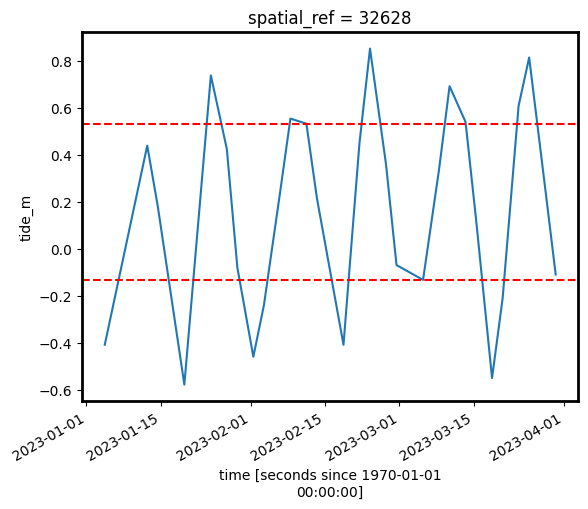

In [12]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = sentinel_2_ds.tide_m.quantile(tide_range) 

# Plot the resulting tide heights for each Landsat image:
sentinel_2_ds.tide_m.plot()
plt.axhline(min_tide, c='red', linestyle='--')
plt.axhline(max_tide, c='red', linestyle='--')
plt.show()


In [13]:
#rgb(sentinel_2_ds,col='time')

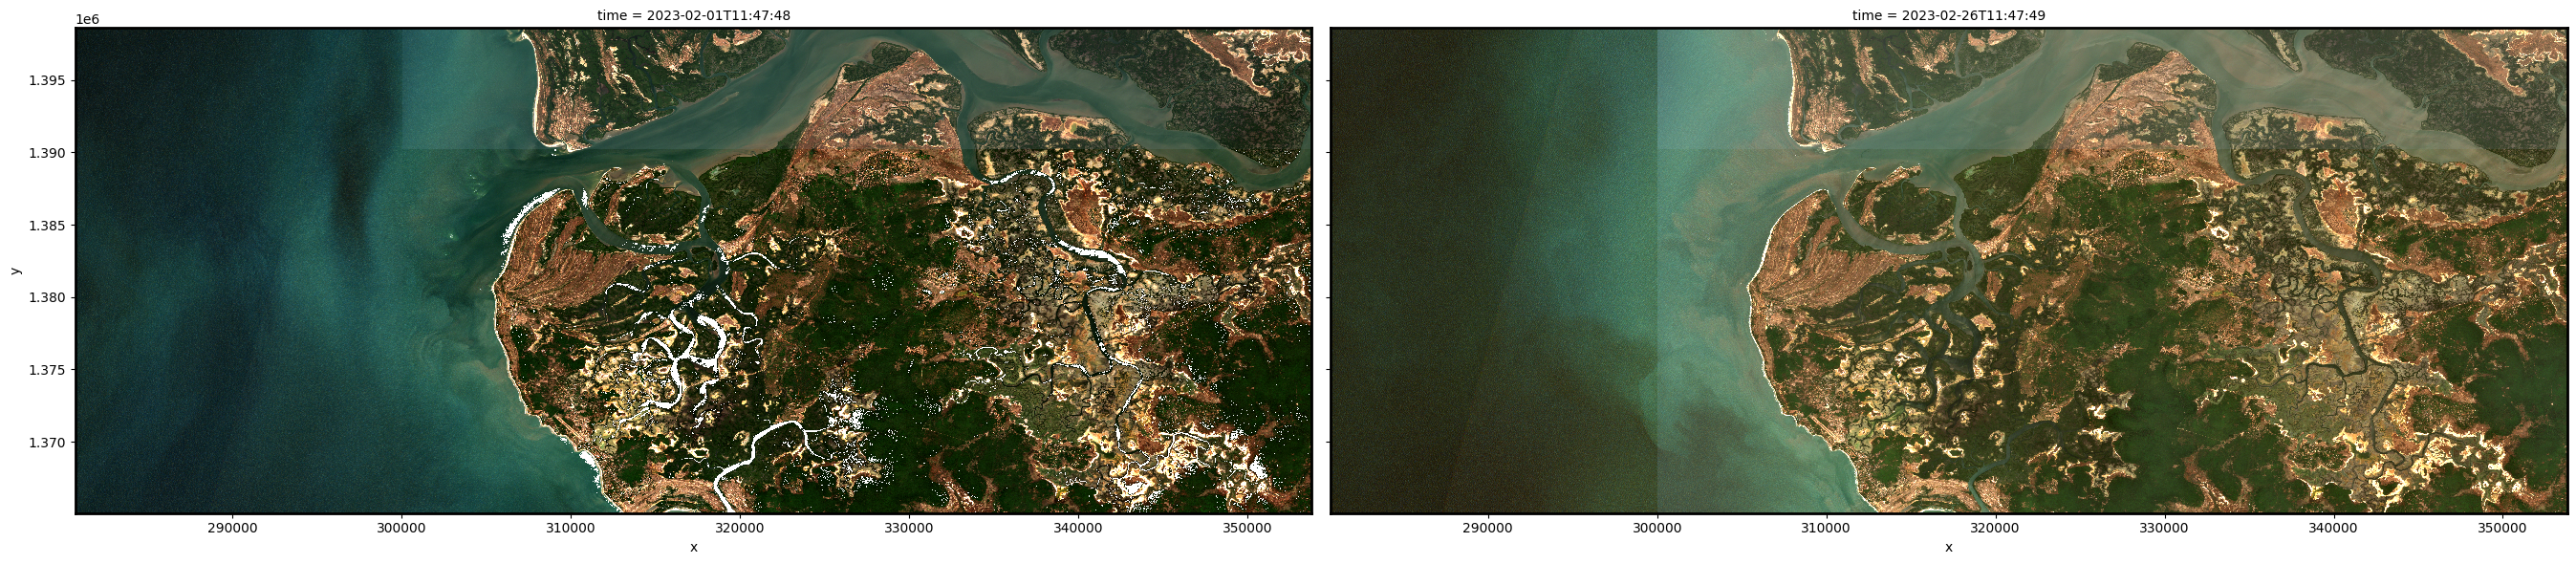

In [14]:
# Set the timesteps to visualise
initial_timestep = 7
final_timestep = 16

# Generate RGB plots at each timestep
rgb(sentinel_2_ds, index=[initial_timestep, final_timestep],
   percentile_stretch=[0.01, 0.99])
plt.show()

## Compute band indices
This study measures the presence of water through the normalised difference water index (NDWI), submerged seagrasses through the Submerged Seagrasses Identification Index (SSII) and the non submerged seagrasses through the normalised difference vegetation index (NDVI).

NDWI is calculated from the green and near infrared (NIR) bands to identify water.
The formula is

$$
\begin{aligned}
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}.
\end{aligned}
$$

NDVI is calculated from the red and near infrared (NIR) bands to identify non submerged seagrasses.
The formula is

$$
\begin{aligned}
\text{NDVI} = \frac{\text{Red} - \text{NIR}}{\text{Red} + \text{NIR}}.
\end{aligned}
$$

SSII is calculated from the  first vegetation red edge band, and a is the adjustment factor, which takes a very small value to 
ensure that the denominator is not 0. The value of 0.00001 was taken in the experiment described in this study. [Li and all (2023)](https://doi.org/10.1016/j.marenvres.2023.105880)
The formula is

$$
\begin{aligned}
\text{SSII} = \frac{\text{Red edge 1} }{\text{Red} + \text{a}}.
\end{aligned}
$$

In [15]:
# Calculate NDWI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDWI", collection="s2")

# Calculate EVI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="EVI", collection="s2")

# Calculate NDVI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDVI", collection="s2")

/tmp/ipykernel_309/3835299324.py:2: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDWI", collection="s2")
/tmp/ipykernel_309/3835299324.py:5: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="EVI", collection="s2")
/tmp/ipykernel_309/3835299324.py:8: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDVI", collection="s2")


INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


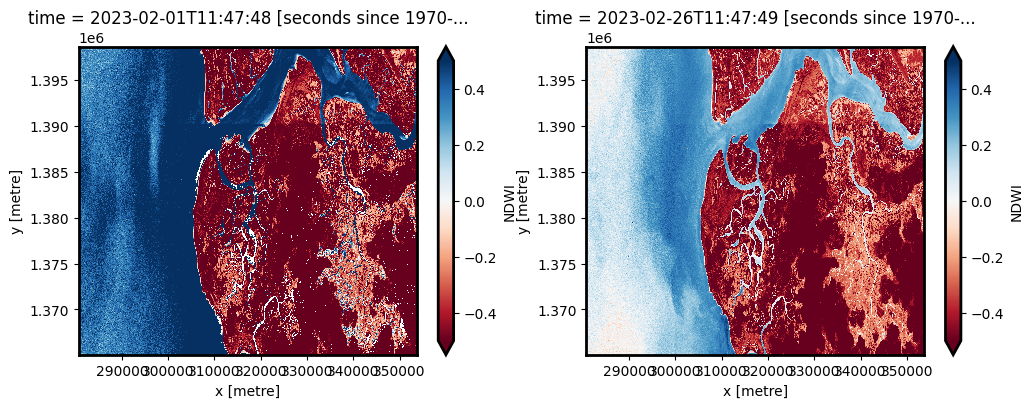

In [17]:
# Plot the resulting image for the same timestep selected above
timestep_1 = 7
timestep_2 = 16

# Plot the resulting image for the same timestep selected above
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sentinel_2_ds.NDWI.isel(time=timestep_1).plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)

sentinel_2_ds.NDWI.isel(time=timestep_2).plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
plt.show()


In [18]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_ha = 100  # conversion from metres to hectares

area_per_pixel = pixel_length**2 / m_per_ha**2

In [23]:
# Filter the data to contain only pixels classified as water
sentinel_2_ds_waterarea = sentinel_2_ds.where(sentinel_2_ds.NDWI.isel(time=timestep_2) > 0.0)

# Calculate the total water area (in ha)
waterarea = (
    sentinel_2_ds_waterarea.NDWI.count(dim=["x", "y"]) * area_per_pixel).persist()

   # .rolling(time=3, center=True, min_periods=1)
   # .median(skipna=True)


In [24]:
a = 0.00001
def SSII(sentinel_2_ds):
    return (sentinel_2_ds.red_edge_1) / (sentinel_2_ds.red + a)

In [25]:
# Calculate the SSII value for Sentinel 2, using water extent to mask
SSII = SSII(sentinel_2_ds_waterarea)

(array([1.37017069e+08, 1.80810000e+04, 3.79200000e+03, 1.02000000e+03,
        2.57000000e+02, 7.90000000e+01, 1.50000000e+01, 1.00000000e+00,
        2.00000000e+00, 1.00000000e+00]),
 array([1.23456782e-02, 9.04441452e+00, 1.80764828e+01, 2.71085510e+01,
        3.61406212e+01, 4.51726875e+01, 5.42047577e+01, 6.32368240e+01,
        7.22688904e+01, 8.13009644e+01, 9.03330307e+01]),
 <BarContainer object of 10 artists>)

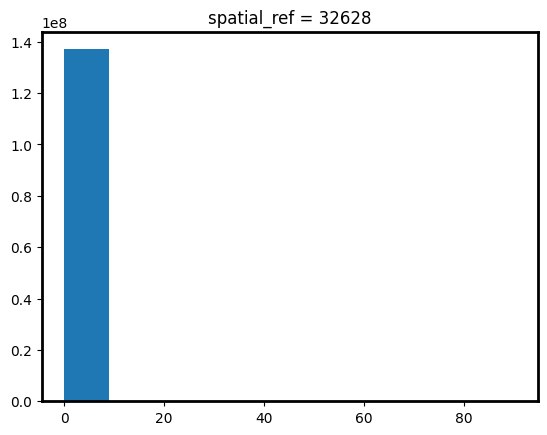

In [22]:
SSII.plot()

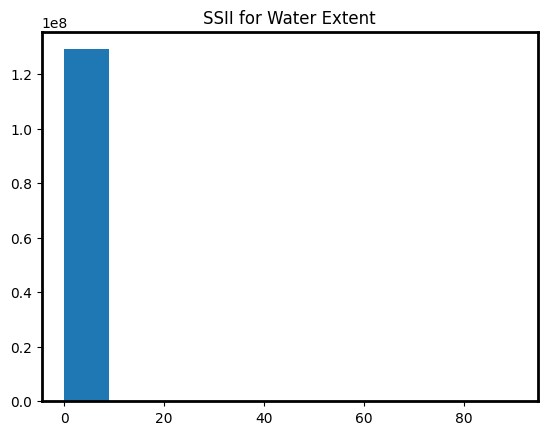

In [26]:
SSII.plot()
plt.title('SSII for Water Extent')
plt.show()


INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


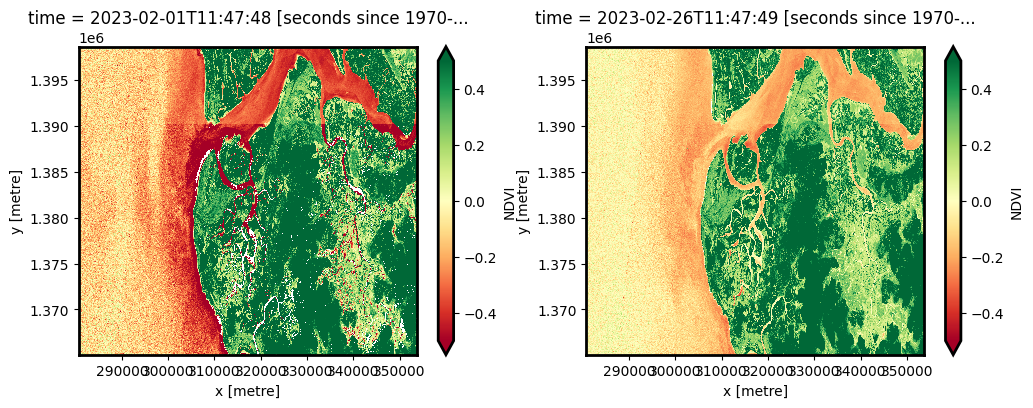

In [27]:
# Plot the resulting image for the same timestep selected above
timestep_1 = 7
timestep_2 = 16

# Plot the resulting image for the same timestep selected above
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sentinel_2_ds.NDVI.isel(time=timestep_1).plot(ax=ax[0], cmap='RdYlGn', vmin=-0.5, vmax=0.5)

sentinel_2_ds.NDVI.isel(time=timestep_2).plot(ax=ax[1], cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.show()


INFO:distributed.core:Event loop was unresponsive in Nanny for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


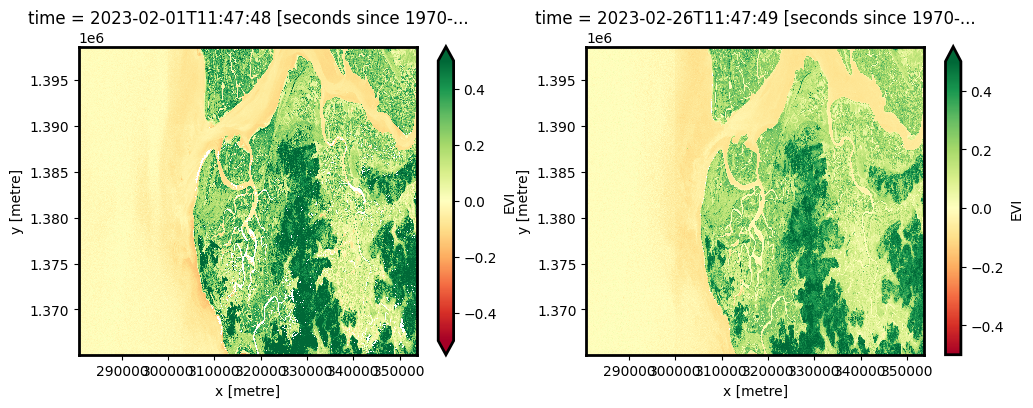

In [28]:
# Plot the resulting image for the same timestep selected above
timestep_1 = 7
timestep_2 = 16

# Plot the resulting image for the same timestep selected above
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sentinel_2_ds.EVI.isel(time=timestep_1).plot(ax=ax[0], cmap='RdYlGn', vmin=-0.5, vmax=0.5)

sentinel_2_ds.EVI.isel(time=timestep_2).plot(ax=ax[1], cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.show()


In [ ]:
# Plot the resulting image for the same timestep selected above
sentinel_2_ds_low.NDVI.plot(cmap='RdYlGn',size=6, vmin=-0.5, vmax=0.5) #cmap='RdYlGn', 
plt.show()